In [1]:
import IPython.core.display         
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import *

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import os
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()

print(keras.__version__, tf.__version__)
K.set_image_data_format('channels_last')
pd.set_option("display.max_columns", None)

ModuleNotFoundError: No module named 'tensorflow_addons'

18632
Index(['image', 'labels'], dtype='object')
AxesSubplot(0.125,0.125;0.775x0.755)


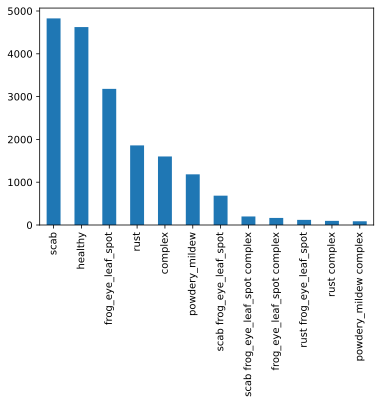

In [2]:
''' reading data '''
train_df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

''' length of train_df'''
print(len(train_df))

''' column names '''
print(train_df.columns)

print(train_df['labels'].value_counts().plot.bar())

In [3]:
train_df = train_df[:1800]

In [4]:
train_df['labels'] = train_df['labels'].apply(lambda string: string.split(' '))
train_df

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
1795,8e77857194a59a87.jpg,[healthy]
1796,8e78fa35c31587c4.jpg,"[rust, frog_eye_leaf_spot]"
1797,8e79802b3fb770c8.jpg,[healthy]
1798,8e7986d1ecd36445.jpg,[healthy]


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               187
frog_eye_leaf_spot    365
healthy               396
powdery_mildew        167
rust                  203
scab                  606
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

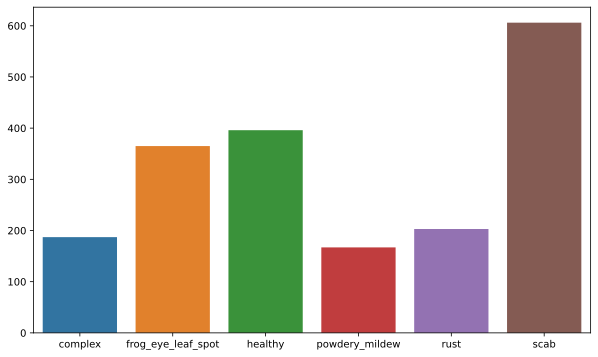

In [5]:
''' list of labels '''
lbls = list(train['labels'])

''' MultiLabelBinarizer '''
lbl_bin = MultiLabelBinarizer()

''' creating dataframe '''
df_train = pd.DataFrame(lbl_bin.fit_transform(s), columns=lbl_bin.classes_, index=train_df.index)

''' column names '''
print(df_train.columns)

''' sum of each class '''
print(df_train.sum())

lbls = list(df_train.sum().keys())
print(lbls)
''' converting to list '''
lbl_counts = df_train.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.barplot(x= lbls, y= lbl_counts, ax=ax);

In [6]:
''' displaying data '''
train_df

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
1795,8e77857194a59a87.jpg,[healthy]
1796,8e78fa35c31587c4.jpg,"[rust, frog_eye_leaf_spot]"
1797,8e79802b3fb770c8.jpg,[healthy]
1798,8e7986d1ecd36445.jpg,[healthy]


In [7]:
%%time
def add_gauss_noise(X, sigma2=0.1):  #0.05
    return X + np.random.normal(0, sigma2, X.shape)

''' Data Augmentation '''
data_gen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True, 
    preprocessing_function=add_gauss_noise, 
    validation_split=0.1
)
batch_size = 16

''' flow from directory '''
train_ds = data_gen.flow_from_dataframe(train_df, directory='../input/resized-plant2021/img_sz_512', x_col="image",
                                        y_col= 'labels', subset="training", color_mode="rgb", target_size = (224,224), 
                                        class_mode="categorical", batch_size=batch_size, shuffle=False, seed=40)

val_ds = datagen.flow_from_dataframe(train_df, directory='../input/resized-plant2021/img_sz_512', x_col="image",
                                     y_col= 'labels', subset="validation", color_mode="rgb",target_size = (224,224), 
                                     class_mode="categorical", batch_size=batch_size, shuffle=False, seed=40)

Found 1620 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
CPU times: user 53.7 ms, sys: 45.4 ms, total: 99.1 ms
Wall time: 498 ms


In [8]:
acc_name = 'f1_score'

''' Accuracy And Loss graph function '''

def plot_hist(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if acc_name in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history[acc_name], 'b', label="training f1_score ({:.4f})".format(history.history[acc_name][-1]))
        ax2.plot(history.history['val_'+acc_name], 'b--', label="validation f1_score ({:.4f})".format(history.history['val_'+acc_name][-1]))

        ax2.legend(loc="lower right", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [9]:
K.clear_session()
''' random seed '''
random.seed(4487); tf.random.set_seed(4487)

''' DenseNet121 Mode '''
w_path = '../input/tf-keras-pretrained-model-weights/No Top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
model1 = tf.keras.applications.DenseNet121(weights=w_path, include_top=False, pooling='avg')

out = model1.output

''' Hidden Layer '''
out = Dense(16, activation='relu')(out)

''' Classification Layer '''
preds = Dense(6, activation='sigmoid')(out)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
102/102 [==============================] - 60s 446ms/step - loss: 0.3710 - f1_score: 0.4608 - val_loss: 0.3081 - val_f1_score: 0.4666
Epoch 2/10
102/102 [==============================] - 38s 376ms/step - loss: 0.1594 - f1_score: 0.8107 - val_loss: 0.2328 - val_f1_score: 0.6910
Epoch 3/10
102/102 [==============================] - 39s 381ms/step - loss: 0.1152 - f1_score: 0.8641 - val_loss: 0.2035 - val_f1_score: 0.7316
Epoch 4/10
102/102 [==============================] - 38s 371ms/step - loss: 0.1003 - f1_score: 0.8960 - val_loss: 0.1888 - val_f1_score: 0.7968
Epoch 5/10
102/102 [==============================] - 39s 379ms/step - loss: 0.0758 - f1_score: 0.8990 - val_loss: 0.2092 - val_f1_score: 0.7760
Epoch 6/10
102/102 [==============================] - 38s 375ms/step - loss: 0.0881 - f1_score: 0.9018 - val_loss: 0.2841 - val_f1_score: 0.7406
Epoch 7/10
102/102 [==============================] - 39s 382ms/step - loss: 0.0463 - f1_score: 0.9401 - val_loss: 0.1929 - val_f1

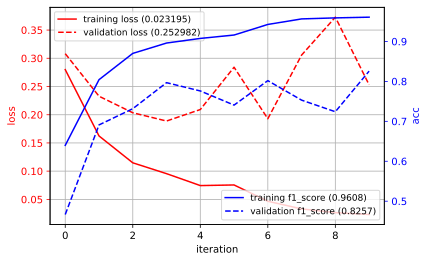

In [10]:
''' final model'''
model = Model(inputs=model1.input, outputs=preds)

''' f1 score'''
f1_sc = tfa.metrics.F1Score(num_classes=6, average='macro')

''' compile the model'''
model.compile(optimizer=keras.optimizers.SGD(lr=0.03, decay=1e-4, momentum=0.8, nesterov=True), 
                 loss='binary_crossentropy', metrics=[f1_sc])

''' Callbacks : EarlyStopping'''
acc_early_stopping = keras.callbacks.EarlyStopping(monitor=f1, min_delta=0.02, patience=5, verbose=1, mode='max', 
                                             restore_best_weights= True)

loss_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=5, verbose=1, mode='min', 
                                                    restore_best_weights= True)

lr_sc = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)

callbacks_list = [acc_early_stopping, loss_early_stopping, lr_sc]

''' training '''
STEP_SIZE_TRAIN = train_ds.n
STEP_SIZE_VALID = val_ds.n
history = model.fit_generator(train_ds, epochs=10, callbacks=callbacks_list, validation_data=valid_data, verbose=True)

''' plotting accuracy and loss graph '''
plot_hist(history)

In [12]:
''' evaluating the model '''
l, f1 = model.evaluate_generator(val_ds,verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


12/12 [==============================] - 3s 282ms/step - loss: 0.2477 - f1_score: 0.8471


In [13]:
''' checking type of val_ds '''
type(val_ds)

tensorflow.python.keras.preprocessing.image.DataFrameIterator

In [14]:
def binary_clf(l_str,th):
    m_id =[]
    for i in l_str:
        if i > th:
            m_id.append(1)
        else:
            m_id.append(0)
    return m_id

def Eval(data, th):
    dictn, count ={}, 0 
    total, right = 0., 0.
    
    for x, y in tqdm(data):
        count = count + 1
        
        ''' prediction '''
        preds= model.predict(x_true)
        pred_list=[]
        for i in preds:
            lbl = binary_clf(i, th)
            lbl = np.array(lbl)
            pred_list.append(lbl)
            
        pred_list = np.array(pre_list)
        
        for i, j in zip(y.tolist(), pred_list.tolist()):
            total += 1
            if i == j:
                right += 1
                
        if (count == ceil(180/batch_size)):
            break
            
    dictn['acc'] = right / total
    dictn['correct'] = right
    dictn['total'] = total
    return dictn

In [15]:
type(np.linspace(0, 1.0, num=20))
th = np.linspace(0, 1.0, num=20)
th[0]

0.0

In [16]:
accuracy_list = []
for th in np.arange(0,1.0,0.05):
    accuracy = Eval(val_ds, threshold)['acc']
    accurac_list.append(accuracy)

 92%|█████████▏| 11/12 [00:04<00:00,  2.43it/s]


In [17]:
max_accuracy = max(accuracy_list)
max_idx = accuracy_list.index(max_accuracy)

ths = np.arange(0,1.0,0.05)

best_th = ths[max_idx]
print("best threshold is {} with the acc {}".format(best_th, max_accuracy))

best threshold is 0.4 with the acc 0.7666666666666667
